# Introduction to Adversarial Machine Learning

*SE2 Current Topics in Data Science, Universitätslehrgang Data Science*

**Date: November 21, 2020**


## Preliminaries

For the practice session, we are going to use the `adversarial-robustness-toolbox` (ART) package, which can be installed via `pip install adversarial-robustness-toolbox[pytorch]`.

ART is a Python library for machine learning security. It provides a broad set of tools to defend and evaluate machine learning models. It covers adversarial threats like evasion, poisoning, extraction and inference attacks as well as suitable defenses. It supports all popular machine learning frameworks.

Today we will use ART in combination with **PyTorch**. We will explosre some common evasion attacks and demonstrate how ART's defense tools can be used.

**Notes:**

The notebook requires some dependencies, which are found in `requirements.txt`. If you haven't installed them yet, please do this now by running the next cell and restarting the notebook afterwards.

We recommend that you run the notebook in an virtual environment.

In [ ]:
%pip install -r requirements.txt

**Agenda:**

1. Initialize Perfect-Knowledge Setting
1. Evasion attacks
 1. Fast Gradient Sign Method
 1. Projected Gradient Descent
 1. Carlini and Wagner $l_2$ attack
1. Spatial Smoothing Defense

## Initialize Perfect-Knowledge Setting

In [1]:
import json
import warnings
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms


from art.utils import ART_DATA_PATH
from art.utils import get_file
from art.estimators.classification import PyTorchClassifier

# disable an annoying depcreation warning that is due to latest ipython
warnings.filterwarnings("ignore", category=DeprecationWarning)

# download imagenet class index
imagenet_labels_uri = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels_path = get_file("imagenet_class_index.json", imagenet_labels_uri)

with open(imagenet_labels_path, "r") as f:
    IMAGENET_CLASS_INDEX = json.load(f)
    
# return label name for label index
def label_name(label_id: int) -> str:
    return IMAGENET_CLASS_INDEX[str(label_id)][-1]

We are mounting our attacks on a ResNet-50 model that is trained on the ImageNet dataset. 

In [2]:
# load a pretrained ResNet-50 model
resnet = models.resnet50(pretrained=True, progress=True)

# define appropriate model loss
loss = torch.nn.CrossEntropyLoss()

The GitHub repositoy [imagenet-stubs](https://github.com/nottombrown/imagenet-stubs/raw/master/imagenet_stubs/images/) hosts a selection of ImageNet samples. We choose the Koala sample and download it. 

PyTorch's model zoo (`torchvision.models`) offers some guidance how the ImageNet samples are to be preprocessed. The following steps are required:

* Load image in to a range of `[0,1]`.
* Standardize the sample with a mean of `(0.485, 0.456, 0.406)` and standard deviation of `(0.229, 0.224, 0.225)`.
* Resize image to `256x256` and center crop to `224x224`.
* Transform image shape to `(batch_size, channels, height, width)`


In [3]:
# download test image
test_image_path = get_file("koala.jpg", 
                           "https://github.com/nottombrown/imagenet-stubs/raw/master/imagenet_stubs/images/koala.jpg")
# test_image_path = get_file("gazelle.jpg", 
#                            "https://github.com/nottombrown/imagenet-stubs/raw/master/imagenet_stubs/images/gazelle.jpg")
# test_image_path = get_file("tractor.jpg", 
#                            "https://github.com/nottombrown/imagenet-stubs/raw/master/imagenet_stubs/images/tractor.jpg")

# define imagenet mean and standard deviation
imagenet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# resisze to 256x256
img = Image.open(test_image_path)
img_resized = img.resize((256, 256), Image.ANTIALIAS)

# center crop to 224x224
def crop_img(img, height, width):
    "Resize image to (256, 256) and center crop to (height, width)."
    img_resized = img.resize((256, 256), Image.ANTIALIAS)

    orig_w, orig_h = img_resized.size
    left = (orig_w - width) // 2
    top = (orig_h - height) // 2
    right = (orig_w + width) // 2
    bottom = (orig_h + height) // 2
    return img.crop((left, top, right, bottom))
img_cropped = crop_img(img_resized, 224, 224)

# convert image to normalized np.ndarray 
x = np.array(img_cropped, dtype=np.float32) / 255

# standardize image
x_preprocessed = (x - imagenet_mean) / imagenet_std

# batchify image and 
x_batch = np.expand_dims(np.transpose(x_preprocessed, (2, 0, 1)), axis=0)

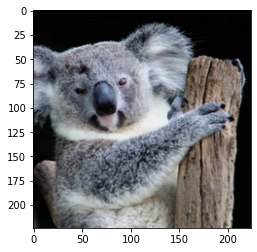

In [4]:
plt.imshow(x)

We have now all our compoments at hands that are required for a perfect-knowledge attack. Remember, that we require

* knowledge over the model $f$ and weights $\mathbf{w}$
* knowledge of the feature space and training data

Now, we can set up a ART classification estimator, which serves as the main interface for the evasion attacks.

In [ ]:
?PyTorchClassifier

In [5]:
# define ART classification estimator
model = PyTorchClassifier(
    resnet,
    loss,
    (1, 3, 224, 224),
    nb_classes=1000,
    channels_first=True
)

# test estimator
print(f"Prediction original: {label_name(np.argmax(model.predict(x_batch)))} ({1 / (1 + np.exp(-np.max(model.predict(x_batch))))})")

Prediction original: koala (0.9999999981472911)


## Evasion attacks

In [6]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method
from art.utils import to_categorical

### Fast Gradient Sign Method

Let's apply an untargeted FGSM attack now.

In [ ]:
?FastGradientMethod

In [7]:
fgsm = FastGradientMethod(
    estimator=model,
    norm=np.inf,
    targeted=False,
    eps=70/255,
    eps_step=1/255,
    batch_size=1,
)

x_adv = fgsm.generate(x_batch, y=None)

print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv))))})")

Prediction adversarial: ice_bear (0.9978339812182796)


Min pixel: 0.0
Max pixel: 1.0


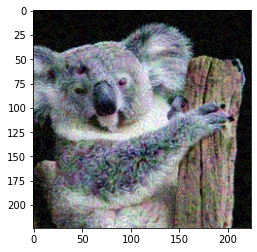

In [8]:
x_adv_unnormalized = np.clip(np.transpose(np.squeeze(x_adv) , (1, 2, 0)) * imagenet_std + imagenet_mean, 0, 1)

print(f"Min pixel: {x_adv_unnormalized.min()}")
print(f"Max pixel: {x_adv_unnormalized.max()}")

plt.imshow(x_adv_unnormalized)

In the following cell, let's  implement the FGSM method ourselvs.

In [9]:
# Note: no need to change anything in this cell

# create device tensor for x_batch
x_tensor = torch.Tensor(x_batch)
x_tensor.requires_grad = True

# calculate loss for (x, y_true) pair
loss_tensor = loss(resnet(x_tensor), torch.LongTensor([105]))

# calculate gradients of loss at x_tensor
resnet.zero_grad()
loss_tensor.backward()
grad = x_tensor.grad.data.numpy()

In [10]:
##################
# Try-yourself 2 #
##################

# To-Do: Apply the FGSM formula (x_adv_self = ...  +  ....)
x_adv_self = x_batch + 70/255 * np.sign(grad)

# To-Do: Undo the standardization
x_adv_self_unnormalized = np.transpose(np.squeeze(x_adv_self) , (1, 2, 0)) * imagenet_std + imagenet_mean

# To-Do: Project the adversarial in the original, unnormalized input space
x_adv_self_unnormalized = np.clip(x_adv_self_unnormalized, 0, 1)

# Bonus: if you have time, try to adapt the code for a targeted attack! Hints:
#        * print IMAGENET_CLASS_INDEX and choose a target label index
#        * replace the label index (105) in the loss_tensor variable
#        * remember that in the targeted variant we want to minimize the loss. What are the
#          consequences thereof?
#        * is FGSM strong enough to succeed?

print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv_self)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv_self))))})")

Prediction adversarial: ice_bear (0.9978339812182796)


Min pixel: 0.0
Max pixel: 1.0


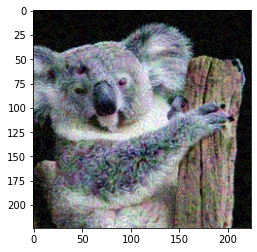

In [11]:
print(f"Min pixel: {x_adv_self_unnormalized.min()}")
print(f"Max pixel: {x_adv_self_unnormalized.max()}")

plt.imshow(x_adv_self_unnormalized)

### Projected Gradient Descent

Let's apply an targeted Projected Gradient Descent attack now.

In [ ]:
?ProjectedGradientDescent

In [12]:
print("Imagenet class index:")
[print(f"\t{idx} -> {label_lst[-1]}") for idx, label_lst in IMAGENET_CLASS_INDEX.items()]

Imagenet class index:
	0 -> tench
	1 -> goldfish
	2 -> great_white_shark
	3 -> tiger_shark
	4 -> hammerhead
	5 -> electric_ray
	6 -> stingray
	7 -> cock
	8 -> hen
	9 -> ostrich
	10 -> brambling
	11 -> goldfinch
	12 -> house_finch
	13 -> junco
	14 -> indigo_bunting
	15 -> robin
	16 -> bulbul
	17 -> jay
	18 -> magpie
	19 -> chickadee
	20 -> water_ouzel
	21 -> kite
	22 -> bald_eagle
	23 -> vulture
	24 -> great_grey_owl
	25 -> European_fire_salamander
	26 -> common_newt
	27 -> eft
	28 -> spotted_salamander
	29 -> axolotl
	30 -> bullfrog
	31 -> tree_frog
	32 -> tailed_frog
	33 -> loggerhead
	34 -> leatherback_turtle
	35 -> mud_turtle
	36 -> terrapin
	37 -> box_turtle
	38 -> banded_gecko
	39 -> common_iguana
	40 -> American_chameleon
	41 -> whiptail
	42 -> agama
	43 -> frilled_lizard
	44 -> alligator_lizard
	45 -> Gila_monster
	46 -> green_lizard
	47 -> African_chameleon
	48 -> Komodo_dragon
	49 -> African_crocodile
	50 -> American_alligator
	51 -> triceratops
	52 -> thunder_snake
	53 -> rin

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [14]:
pgd = ProjectedGradientDescent(
    estimator=model,
    norm=np.inf,
    targeted=True,
    eps=5/255,
    eps_step=1/255,
    max_iter=6,
    batch_size=1,
)

y_target = to_categorical([285], nb_classes=1000) 
x_adv = pgd.generate(x_batch, y=y_target)

print(f"Target label: {label_name(285)}")
print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv))))})")

PGD - Random Initializations: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


Target label: Egyptian_cat
Prediction adversarial: Egyptian_cat (0.9995147297219494)


Min pixel: 0.0
Max pixel: 0.9725490808486938


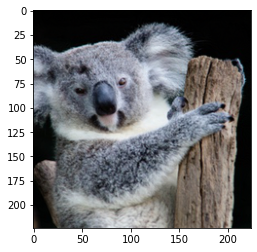

In [15]:
x_adv_unnormalized = np.clip(np.transpose(np.squeeze(x_adv) , (1, 2, 0)) * imagenet_std + imagenet_mean, 0, 1)

print(f"Min pixel: {x_adv_unnormalized.min()}")
print(f"Max pixel: {x_adv_unnormalized.max()}")

plt.imshow(x_adv_unnormalized)

Next, let's try to make our previous FGSM iterative and project the perturbation $\delta$ on the $l_\infty$-ball.

In [16]:
##################
# Try-yourself 2 #
##################

# define
x_torch_orig = torch.from_numpy(x_batch)
x_torch_adv = torch.from_numpy(x_batch)

# try to run multiple iterations. What's the smallest number of iterations you need?
for i in range(6):
    # we require gradients for the attack
    x_torch_adv.requires_grad = True

    # To-Do: calculate loss for (x, y_true) pair (tip: check some of the previous cells)
    loss_tensor = loss(resnet(x_torch_adv), torch.LongTensor([285]))
    
    # zero gradients
    resnet.zero_grad()

    # backward pass on loss
    loss_tensor.backward()
    
    # get gradients
    grad = x_torch_adv.grad.data
    
    with torch.no_grad():
        # To-Do: peform a gradient descent step with step size of 1/255
        x_torch_adv = x_torch_adv - 1/255 * grad.sign()
        
        # To-Do: clip perturbation delta at 5/255
        delta = torch.clip(x_torch_adv - x_torch_orig, min=-5/255, max=5/255)
        
        # re-apply delta to original example
        x_torch_adv = x_torch_orig + delta

# save adversarial as numpy array        
x_adv = x_torch_adv.detach().numpy()

In [17]:
print(f"Target label: {label_name(285)}")
print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv))))})")    

Target label: Egyptian_cat
Prediction adversarial: Egyptian_cat (0.9995147297219494)


### Carlini and Wagner $l_2$ attack

In [ ]:
?CarliniL2Method

In [18]:
cw = CarliniL2Method(
    classifier=model,
    targeted=True,
    confidence=0.0,
    max_iter=10,
    batch_size=1,
)

y_target = to_categorical([285], nb_classes=1000) 
x_adv = cw.generate(x_batch, y=y_target)

print(f"Target label: {label_name(285)}")
print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv))))})")

C&W L_2: 100%|██████████| 1/1 [02:09<00:00, 129.77s/it]


Target label: Egyptian_cat
Prediction adversarial: Egyptian_cat (0.993187272640937)


## Spatial Smoothing Defense

ART also provides a set of defenses. Namely, pre- and postprocessing defenses as well as adversarial training. We will use the spatial smoothing defense and try to circumvent it afterwards.

In [20]:
from art.defences.preprocessor import SpatialSmoothing

In [21]:
# define spatial smoothing defense
defense = SpatialSmoothing(window_size=3)

# re-generate adversarial example with PGD
pgd = ProjectedGradientDescent(
    estimator=model,
    norm=np.inf,
    targeted=True,
    eps=5/255,
    eps_step=1/255,
    max_iter=20,
    batch_size=1,
)

y_target = to_categorical([285], nb_classes=1000) 
x_adv = pgd.generate(x_batch, y=y_target)

# apply defense to original and adversarial example
x_batch_defense, _ = defense(x_batch)
x_adv_defense, _ = defense(x_adv)

print(f"Target label: {label_name(285)}")
print(f"Prediction adversarial: {label_name(np.argmax(model.predict(x_adv)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv))))})")
print(f"Prediction original after defense: {label_name(np.argmax(model.predict(x_batch_defense)))} ({1 / (1 + np.exp(-np.max(model.predict(x_batch_defense))))})")
print(f"Prediction adversarial after defense: {label_name(np.argmax(model.predict(x_adv_defense)))} ({1 / (1 + np.exp(-np.max(model.predict(x_adv_defense))))})")

PGD - Random Initializations: 100%|██████████| 1/1 [00:09<00:00,  9.45s/it]


Target label: Egyptian_cat
Prediction adversarial: Egyptian_cat (0.9999999998722133)
Prediction original after defense: koala (0.9999999790341794)
Prediction adversarial after defense: koala (0.9999998841445566)


Min pixel: 0.0
Max pixel: 0.9603921175003052


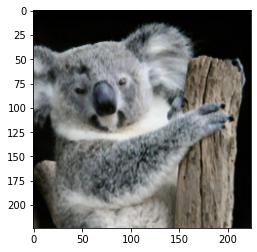

In [22]:
x_adv_defense_unnormalized = np.clip(np.transpose(np.squeeze(x_adv_defense) , (1, 2, 0)) * imagenet_std + imagenet_mean, 0, 1)

print(f"Min pixel: {x_adv_defense_unnormalized.min()}")
print(f"Max pixel: {x_adv_defense_unnormalized.max()}")

plt.imshow(x_adv_defense_unnormalized)

Now let's try to employ an adaptive whitebox attack to defeat the spatial smoothing defense.

In [23]:
##################
# Try-yourself 3 #
##################

# define spatial smoothing defense
defense = SpatialSmoothing(window_size=3)

# define adaptive classifier
model_adaptive = PyTorchClassifier(
    resnet,
    loss,
    (1, 3, 224, 224),
    nb_classes=1000,
    channels_first=True,
    # To-Do: Have a look a the documentation. What possible argument could be useful?
    preprocessing_defences=[defense],
)


# re-generate adversarial example with PGD
pgd_adaptive = ProjectedGradientDescent(
    estimator=model_adaptive,
    norm=np.inf,
    targeted=True,
    eps=5/255,
    eps_step=1/255,
    batch_size=1,
    # To-Do: Play around with max_iter. How many iterations are required?
    max_iter=6,
)

y_target = to_categorical([285], nb_classes=1000) 
x_adv_adaptive = pgd_adaptive.generate(x_batch, y=y_target)

print(f"Target label: {label_name(285)}")
print(f"Prediction adversarial adaptive: {label_name(np.argmax(model_adaptive.predict(x_adv_adaptive)))} ({1 / (1 + np.exp(-np.max(model_adaptive.predict(x_adv_adaptive))))})")

PGD - Random Initializations: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


Target label: Egyptian_cat
Prediction adversarial adaptive: Egyptian_cat (0.9999252631804507)


Min pixel: 0.0
Max pixel: 0.9725490808486938


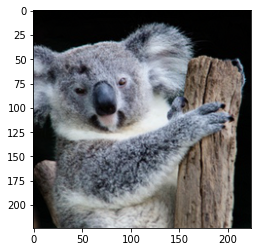

In [24]:
x_adv_adaptive_unnormalized = np.clip(np.transpose(np.squeeze(x_adv_adaptive) , (1, 2, 0)) * imagenet_std + imagenet_mean, 0, 1)

print(f"Min pixel: {x_adv_adaptive_unnormalized.min()}")
print(f"Max pixel: {x_adv_adaptive_unnormalized.max()}")

plt.imshow(x_adv_adaptive_unnormalized)